In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
from skimage import io
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

import warnings
warnings.simplefilter("ignore")

# Download Data using Kaggle API

https://www.kaggle.com/docs/api

https://www.kaggle.com/general/74235

## Coco Dataset

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle                 #make directory(folder) named .kaggle
 
! cp kaggle.json ~/.kaggle/       #add file to that folder
 
! chmod 600 ~/.kaggle/kaggle.json        #Change the permissions of the file.

In [ ]:
! kaggle datasets download oishee30/cocopersonsegmentation

print(os.listdir('/content'))

In [ ]:
! mkdir data        #making directory data
 
! unzip cocopersonsegmentation.zip -d data            #unzipping data into data directory

In [ ]:
os.remove('/content/cocopersonsegmentation.zip')
print(os.listdir('/content'))

In [ ]:
os.listdir('/content/data')

In [ ]:
path = '/content/data'
for folder in os.listdir(path):
  if '.txt' not in folder:
    print('No of images in',folder,len(os.listdir(path+'/'+folder)))

In [ ]:
xpath_coco = '/content/data/train2017_new/'
ypath_coco = '/content/data/train2017_ann/'
x_test_path = '/content/data/val2017_new/'
y_test_path = '/content/data/val2017_ann/'

In [ ]:
input_img_paths_coco = sorted([os.path.join(xpath_coco, fname) for fname in os.listdir(xpath_coco)])
target_img_paths_coco = sorted([os.path.join(ypath_coco, fname) for fname in os.listdir(ypath_coco)])

print(len(input_img_paths_coco), len(target_img_paths_coco))
for input_path, target_path in zip(input_img_paths_coco[:4], target_img_paths_coco[:4]):
    print(input_path, "|", target_path)

## Another Data

In [ ]:
! kaggle datasets download furkankati/person-segmentation-dataset

print(os.listdir('/content'))

In [ ]:
! unzip person-segmentation-dataset.zip -d data

In [ ]:
os.remove('/content/person-segmentation-dataset.zip')
print(os.listdir('/content'))

In [ ]:
os.listdir('/content/data/')

In [ ]:
path = '/content/data/Training/'
for folder in os.listdir(path):
  if ('.txt' not in folder) and ('.hdf' not in folder) :
    print('No of images in',folder,len(os.listdir(path+folder)))

In [ ]:
xpath_89k = '/content/data/Training/input/'
ypath_89k = '/content/data/Training/Output/'

In [ ]:
xpath_89k = '/content/data/Training/input/'
ypath_89k = '/content/data/Training/Output/'
 
input_img_paths_89k = sorted([os.path.join(xpath_89k, fname) for fname in os.listdir(xpath_89k)])
target_img_paths_89k = sorted([os.path.join(ypath_89k, fname) for fname in os.listdir(ypath_89k)])

In [ ]:
input_img_paths_89k = sorted([os.path.join(xpath_89k, fname) for fname in os.listdir(xpath_89k)])
target_img_paths_89k = sorted([os.path.join(ypath_89k, fname) for fname in os.listdir(ypath_89k)])

print(len(input_img_paths_89k), len(target_img_paths_89k))
for input_path, target_path in zip(input_img_paths_89k[:4], target_img_paths_89k[:4]):
    print(input_path, "|", target_path)

# Prepare Datset for training



In [ ]:
train_input_img_paths = input_img_paths_coco.copy()
target_input_img_paths = target_img_paths_coco.copy()

print(len(train_input_img_paths), len(target_input_img_paths))

In [ ]:
for img in input_img_paths_89k:
  train_input_img_paths.append(img)
 
for img in target_img_paths_89k:
  target_input_img_paths.append(img)

print(len(train_input_img_paths), len(target_input_img_paths))

In [ ]:
train_input_img_paths = sorted(train_input_img_paths)    #sorting
train_target_img_paths = sorted(target_input_img_paths)   #sorting
 
val_input_img_paths = sorted([os.path.join(x_test_path, fname) for fname in os.listdir(x_test_path)])
val_target_img_paths = sorted([os.path.join(y_test_path, fname) for fname in os.listdir(y_test_path)])
 
print("Number of training samples:", len(train_input_img_paths))
print("Number of validation samples:", len(val_input_img_paths))
 
for input_path, target_path in zip(train_input_img_paths[:4], train_target_img_paths[:4]):
    print(input_path, "|", target_path)

In [ ]:
n_images = 5
for i in np.random.randint(0,len(train_input_img_paths),n_images):
 
  fig = plt.figure(figsize=(12,6))
  fig.tight_layout()
 
  plt.subplot(1,2,1)
  img = plt.imread(train_input_img_paths[i])
  plt.imshow(img)
  plt.title('Image')
 
  plt.subplot(1,2,2)
  img = plt.imread(train_target_img_paths[i])
  plt.imshow(img)
  plt.title('Mask')
 
  plt.show()
  print()

In [ ]:
mask = plt.imread(train_target_img_paths[0])
print(np.unique(mask, return_counts= True))
print(mask.shape)
sns.countplot(mask.ravel())
plt.show()

In [ ]:
mask = plt.imread(train_target_img_paths[-1])
print(np.unique(mask, return_counts= True))
print(mask.shape)
sns.countplot(mask.ravel())
plt.show()

In [ ]:
batch_size = 32
img_size = (256,256)

class Data_Gen(keras.utils.Sequence):
    """Helper function to iterate over the data (as Numpy arrays)."""
 
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
 
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size                    # 64115//32
 
    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size                                                            # 0
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]                # [0: 0+32]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
 
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")           #(32,256,256,3)
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            img = np.array(img)/255
            x[j] = img
 
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")             #(32,256,256,1)
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")        #(256,256)
            img = np.array(img)
            img[img!=0] = 1
            y[j] = np.expand_dims(img, 2)                                                  #(256,256,1)
 
        return x, y

In [ ]:
# checking gererator function
train_gen = Data_Gen(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = Data_Gen(batch_size, img_size, val_input_img_paths, val_target_img_paths)
x, y = train_gen.__getitem__(0)
print(x.shape, y.shape)

In [ ]:
print(y[0].shape)
print(np.unique(y[0], return_counts= True))

# Model Building

In [ ]:
def downblock(filters, filter_size, previous_layer):
  x = layers.Conv2D(filters, filter_size, padding="same")(previous_layer)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
 
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
  x = layers.BatchNormalization()(x)
  
  residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
  x = layers.add([x, residual])  # Add back residual
 
  x = layers.Activation("relu")(x)
  p = layers.MaxPooling2D(2)(x)
 
  return x,p
 
def bottleneck(filters, filter_size, previous_layer):
  x = layers.Conv2D(filters, filter_size, padding="same")(previous_layer)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Dropout(.5)(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
 
  residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
  x = layers.add([x, residual])  # Add back residual
  
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
 
  return x
 
def upblock(filters, filter_size, previous_layer, layer_to_concat):
  x = layers.Conv2DTranspose(filters, filter_size, strides=2, padding="same")(previous_layer)       #upconvolution
  concat = layers.concatenate([x, layer_to_concat])                                                      #concatenation
 
  x = layers.Conv2D(filters, filter_size, padding="same")(concat)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
  x = layers.BatchNormalization()(x)
 
  residual = layers.Conv2D(filters, 1, padding="same")(concat)      #separate layer for addintion
  x = layers.add([x, residual])  # Add back residual
  
  x = layers.Activation("relu")(x)
 
  return x

In [ ]:
input_layer = layers.Input(shape = img_size + (3,))
 
conv1, pool1 = downblock(32, 3, input_layer)
conv2, pool2 = downblock(64, 3, pool1)
conv3, pool3 = downblock(128, 3, pool2)
 
conv4 = bottleneck(256,3,pool3)
 
upconv1 = upblock(128, 3, conv4, conv3)
upconv2 = upblock(64, 3, upconv1, conv2)
upconv3 = upblock(32, 3, upconv2, conv1)
 
output_layer = layers.Conv2D(1, 1, padding="same", activation='sigmoid')(upconv3)
model = keras.Model(input_layer, output_layer)
model.summary()

In [ ]:
img_file = "/content/drive/MyDrive/Colab Notebooks/Background_remover/combined.png"
tf.keras.utils.plot_model(model, to_file= img_file, show_shapes=True, show_layer_names=True)

In [ ]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
 
model.compile(optimizer=opt, loss="binary_crossentropy", 
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])    #metrics=[tf.keras.metrics.MeanIoU(num_classes=2)]
 
filepath = "/content/drive/MyDrive/Colab Notebooks/Background_remover/modelcombined_{epoch:00d}_{val_loss:03f}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_best_only= False)
 
callbacks = [checkpoint]

In [ ]:
start = datetime.now()
 
# Train the model, doing validation at the end of each epoch.
epochs = 4
model_history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
 
end = datetime.now()
print(f'Time take to train {epochs} epochs is:', start - end)

In [ ]:
model_history.history 

In [3]:
'''
1/5
4810/4810 [==============================] - 3722s 765ms/step - loss: 0.2582 - accuracy: 0.8925 - mean_io_u: 0.4290 - val_loss: 0.2502 - val_accuracy: 0.8997 - val_mean_io_u: 0.4162
Epoch 2/5
4810/4810 [==============================] - 3673s 764ms/step - loss: 0.1537 - accuracy: 0.9363 - mean_io_u: 0.4291 - val_loss: 0.2566 - val_accuracy: 0.9046 - val_mean_io_u: 0.4162
Epoch 3/5
4810/4810 [==============================] - 3672s 763ms/step - loss: 0.1354 - accuracy: 0.9443 - mean_io_u: 0.4288 - val_loss: 0.2920 - val_accuracy: 0.9030 - val_mean_io_u: 0.4162

'''

'\n1/5\n4810/4810 [==============================] - 3722s 765ms/step - loss: 0.2582 - accuracy: 0.8925 - mean_io_u: 0.4290 - val_loss: 0.2502 - val_accuracy: 0.8997 - val_mean_io_u: 0.4162\nEpoch 2/5\n4810/4810 [==============================] - 3673s 764ms/step - loss: 0.1537 - accuracy: 0.9363 - mean_io_u: 0.4291 - val_loss: 0.2566 - val_accuracy: 0.9046 - val_mean_io_u: 0.4162\nEpoch 3/5\n4810/4810 [==============================] - 3672s 763ms/step - loss: 0.1354 - accuracy: 0.9443 - mean_io_u: 0.4288 - val_loss: 0.2920 - val_accuracy: 0.9030 - val_mean_io_u: 0.4162\n\n'

In [4]:
history = {'loss': [0.2582,0.1537,0.1354],
           'accuracy': [0.8925,0.9363,0.9443],
           'mean_io_u': [0.4290,0.4291,0.4288],
           'val_loss': [0.2502,0.2566,0.2920],
           'val_accuracy': [0.8997,0.9046,0.9030],
           'val_mean_io_u': [0.4162,0.4162,0.4162]
}

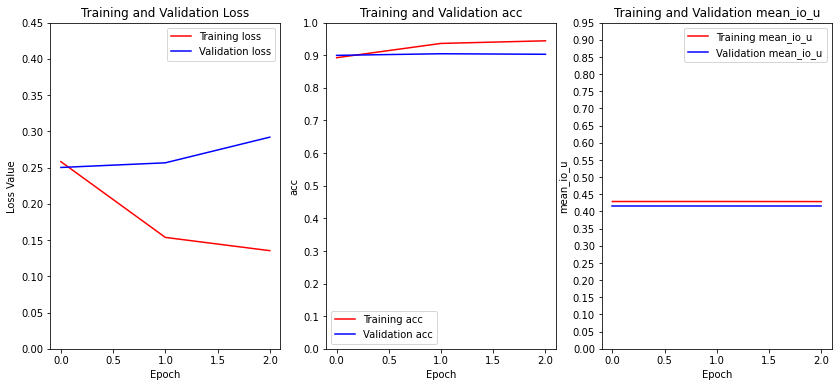

In [8]:
train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']
train_iou = history['mean_io_u']
val_iou = history['val_mean_io_u']

plt.figure(figsize=(14,6))

plt.subplot(1,3,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.yticks(np.arange(0, .5,.05))
plt.legend()

plt.subplot(1,3,2)
plt.plot(train_acc, 'r', label='Training acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.yticks(np.arange(0,1.1,.1))
plt.legend()

plt.subplot(1,3,3)
plt.plot(train_iou, 'r', label='Training mean_io_u')
plt.plot(val_iou, 'b', label='Validation mean_io_u')
plt.title('Training and Validation mean_io_u')
plt.xlabel('Epoch')
plt.ylabel('mean_io_u')
plt.yticks(np.arange(0,1,.05))
plt.legend()
plt.show()

# Testing

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Background_remover/modelcombined_04_0.238711.h5")

In [ ]:
def ploting(imgpath, maskpath):
  plt.figure(figsize=(12,4))

  im = io.imread(imgpath)
  im = cv2.resize(im,img_size)
  im = np.array(im)/255

  plt.subplot(1,3,1)
  plt.title('Original')
  plt.imshow(im)

  im = im.reshape((1,)+im.shape)
  im.shape

  pred = model.predict(im)
  
  p = pred.copy()
  p = p.reshape(p.shape[1:-1])

  p[np.where(p>.2)] = 1
  p[np.where(p<.2)] = 0

  im = io.imread(imgpath)
  im = cv2.resize(im,img_size)
  im = np.array(im)

  im[:,:,0] = im[:,:,0]*p 
  im[:,:,0][np.where(p!=1)] = 247
  im[:,:,1] = im[:,:,1]*p 
  im[:,:,1][np.where(p!=1)] = 231
  im[:,:,2] = im[:,:,2]*p
  im[:,:,2][np.where(p!=1)] = 230

  plt.subplot(1,3,2)
  plt.imshow(im)
  
  if maskpath:
    plt.subplot(1,3,3)
    mask = io.imread(maskpath)
    plt.imshow(mask)

    plt.show()

In [ ]:
n_images = 5
for i in np.random.randint(0,len(val_input_img_paths),n_images):
  ploting(val_input_img_paths[i], val_target_img_paths[i])

# The End